In [28]:

# coding: utf-8

# In[1]:

import pandas as pd
import geopandas as gpd
import re
import numpy as np
import os
import argparse
from datetime import datetime


# parser = argparse.ArgumentParser(description='Refine ruw CSV for prioritering')
# parser.add_argument('csv_in', type=str, default=r'D:\OmsWaddenzee\trunk\fews\Modules\prioriteringExport\Csv//prioritering_ruw.csv', nargs='?',
#                    help='exported generalCSV bestand [prioritering_ruw.csv]')
# parser.add_argument('csv_out', type=str, default=r'D:\OmsWaddenzee\trunk\fews\Modules\prioriteringExport\Csv//prioritering_refined.csv', nargs='?',
#                    help='refined CSV bestand [prioritering_refined.csv]')
# parser.add_argument('baggervakken', type=str, default=r'D:\OmsWaddenzee\trunk\fews\Config\MapLayerFiles\Baggervakken//Baggervakken.shp', nargs='?',
#                    help='shapefile met baggervakken')
# parser.add_argument('json_out', type=str, default=r'D:\OmsWaddenzee\trunk\fews\prioriteringExport\Csv//prioritering_refined.geojson', nargs='?',
#                    help='refined GeoJSON bestand [prioritering_refined.geojson')

# args = parser.parse_args()

# In[2]:

# location on drive
#csv_in = r'D:\OmsWaddenzee\trunk\fews\Modules\prioriteringExport\Csv//prioritering_ruw.csv'
csv_in = r'D:/Projects/Pr/3317.30/Tests/PrioriteringGeojsonError/prioritering_ruw.csv'
csv_out = r'D:/OmsWaddenzee/trunk/fews/Config/MapLayerFiles/Baggervakken/Baggervakken.shp'
baggervakken = r'D:/OmsWaddenzee/trunk/fews/Config/MapLayerFiles/Baggervakken/Baggervakken.shp'
json_out = r'D:/Projects/Pr/3317.30/Tests/PrioriteringGeojsonError/prioritering_refined.geojson'

# read the baggervakken.shp
# read the geodataframe
gdf = gpd.read_file(args.baggervakken)

# get list of duplicates (both the first and last [and middles if available])
duplicates_all = gdf[gdf['OBJECTCODE'].duplicated(keep=False)]
for obj in duplicates_all['OBJECTCODE'].unique():
    duplicates_single = duplicates_all.loc[duplicates_all['OBJECTCODE']==obj]
    rows2drop = duplicates_single.loc[duplicates_single['END'] != duplicates_single['END'].max()]
    gdf.drop(rows2drop.index.tolist(), axis=0, inplace=True)


# In[37]:

gdf['AREA'] = gdf['geometry'].area
#gdf.to_crs(epsg=4326, inplace=True)


# In[38]:

gdf_area = gdf[['OBJECTNAAM','OBJECTCODE','AREA','ACTIVITEIT','DIEPTE_MIN','DIEPTE_MAX','geometry']]
gdf_area.columns = ['Objectnaam', 'Objectcode', 'Oppervlak (m2)', 'Activiteit',
       'NGD (-mNAP)', 'OHD (-mNAP)','geometry']
gdf_area['Objectcode'] = 'bv.' + gdf_area['Objectcode'].astype(str)


# In[40]:

# read into dataframe
df_csv = pd.read_csv(args.csv_in, sep=';')
#df_csv['Datum'] = pd.to_datetime(df_csv['Datum'])

# BE CAREFUL THIS ONLY WORKS IF THE FEWS HUIDIGE SYSTEEMTIJD IS SET TO TODAY
# SO A FEWS SYSTEEMTIJD IN THE PAST WON'T GIVE YOU ANY OUTPUT
df_csv = df_csv[df_csv['Datum'] == datetime.today().strftime('%Y-%m-%d')]

# join dataframes on objectcode
df_comb = pd.merge(df_csv, gdf_area, left_on='Baggervak', right_on='Objectcode')

# but keep geodataframe functionality
df_comb = gpd.GeoDataFrame(df_comb)
df_comb['Oppervlak (m2)'] = df_comb['Oppervlak (m2)'].astype(float).apply(np.ceil)
df_comb['Oppervlakte cut tov NGD (m2)'] = df_comb['Oppervlakte cut tov NGD (m2)'].astype(float).apply(np.floor)
df_comb['Oppervlakte cut tov OHD (m2)'] = df_comb['Oppervlakte cut tov OHD (m2)'].astype(float).apply(np.floor)


# In[46]:

# calculate the prioritering
df_comb['Percentage cut tov NGD (%)'] = (df_comb['Oppervlakte cut tov NGD (m2)'] / df_comb['Oppervlak (m2)'] * 100).round(2)
df_comb['Percentage cut tov OHD (%)'] = (df_comb['Oppervlakte cut tov OHD (m2)'] / df_comb['Oppervlak (m2)'] * 100).round(2)

df_comb['Gemiddelde dikte cut tov NGD (cm)'] = np.round(df_comb['Gemiddelde dikte cut tov NGD (cm)'], 0).astype(int)
df_comb['Gemiddelde dikte cut tov OHD (cm)'] = np.round(df_comb['Gemiddelde dikte cut tov OHD (cm)'], 0).astype(int)
df_comb['Percentage cut tov NGD (%)'] = np.ceil(df_comb['Percentage cut tov NGD (%)']).astype(int)
df_comb['Percentage cut tov OHD (%)'] = np.ceil(df_comb['Percentage cut tov OHD (%)']).astype(int)
df_comb['Volume cut tov NGD (m3)'] = np.ceil(df_comb['Volume cut tov NGD (m3)']).astype(int)
df_comb['Volume cut tov OHD (m3)'] = np.ceil(df_comb['Volume cut tov OHD (m3)']).astype(int)

df_comb['NGD (-mNAP)'].replace(-999,np.nan, inplace=True)
df_comb['NGD (-mNAP)'].fillna('niet bekend', inplace=True)

df_comb['OHD (-mNAP)'].replace(-999,np.nan, inplace=True)
df_comb['OHD (-mNAP)'].fillna('niet bekend', inplace=True)

# reorder columns 
c = df_comb.columns.tolist()

c_selection = ['Objectcode',
               'Objectnaam',
               'Activiteit',
               'NGD (-mNAP)',
               'OHD (-mNAP)',               
               'Volume cut tov NGD (m3)',
               'Volume cut tov OHD (m3)',               
               'Percentage cut tov NGD (%)',
               'Percentage cut tov OHD (%)',
               'Gemiddelde dikte cut tov NGD (cm)',
               'Gemiddelde dikte cut tov OHD (cm)',
              ]


# In[47]:

# # save as csv
df_comb[c_selection].to_csv(args.csv_out, sep=',', index=False)


# In[48]:

# and prepare geojson for overlay
# append selection with geometry and change column names using a list comprehension to remove parentheses
# and trainling spaces while replacing the remaining spaces with underscores
c_selection.append('geometry')
df_comb = df_comb[c_selection]
df_comb.columns = [re.sub("[\(\[].*?[\)\]]", "", n).rstrip().replace(" ", "_") for n in c_selection]

# save to json
# overwrite bug in fiona https://github.com/geopandas/geopandas/issues/367   
try: 
    os.remove(json_out)
except OSError:
    pass


# In[50]:

df_comb.to_file(args.json_out, driver='GeoJSON')

print('end of script')

end of script


c:\python35\lib\site-packages\ipykernel\__main__.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


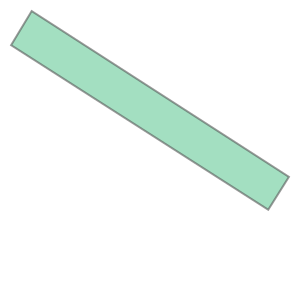

In [40]:
%matplotlib inline
df_comb.geometry[3]

In [24]:
df_csv = df_csv[df_csv['Datum'] == datetime.now().strftime('%Y-%m-%d')]

,Datum,Baggervak,Volume cut tov NGD (m3),Volume cut tov OHD (m3),Volume fill tov NGD (m3),Volume fill tov OHD (m3),Oppervlakte cut tov NGD (m2),Oppervlakte cut tov OHD (m2),Oppervlakte fill tov NGD (m2),Oppervlakte fill tov OHD (m2),Gemiddelde dikte cut tov NGD (cm),Gemiddelde dikte cut tov OHD (cm),Gemiddelde dikte fill tov NGD (cm),Gemiddelde dikte fill tov OHD (cm)
0,2017-08-08,bv.1.7.2.3.2,2834.83,48540.00,-480255.00,-284758.68,19005.00,165297.00,462004.00,314147.00,0.59,10.06,-99.55,-59.03
1,2017-08-08,bv.1.7.1.3.1,107.37,2754.60,-268851.76,-206167.50,614.00,12180.00,129954.00,118065.00,0.08,2.11,-205.76,-157.79
2,2017-08-08,bv.1.7.3.1.1,2221.36,10078.95,-157824.25,-119916.64,17682.00,62627.00,209606.00,163265.00,0.97,4.40,-68.97,-52.41
3,2017-08-08,bv.1.7.3.1.2.A,199.41,741.21,-48300.89,-43021.18,1410.00,4050.00,27596.75,24909.75,0.68,2.53,-165.04,-147.00
4,2017-08-08,bv.1.7.3.1.3,40.77,144.37,-39909.79,-32339.99,202.00,967.00,38142.00,37343.00,0.11,0.38,-104.02,-84.29
5,2017-08-08,bv.1.7.4.1.2,24.24,9733.72,-26288.59,-10772.07,34.00,34716.00,50396.00,15632.00,0.05,19.24,-51.96,-21.29
6,2017-08-08,bv.1.7.2.1.1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,2017-08-08,bv.1.7.3.1.2.B,2021.05,2916.50,-56053.05,-42563.30,3061.00,5995.00,68667.00,65606.00,6.00,8.66,-166.43,-126.38
8,2017-08-08,bv.1.7.2.3.3,51.31,1788.03,-2710498.88,-2476863.20,469.00,8759.00,469928.00,461393.00,0.01,0.38,-575.79,-526.16
9,2017-08-08,bv.1.7.3.2.1.2,9.87,446.20,-7560.26,-2397.09,32.00,4005.00,11167.00,7061.00,0.09,3.98,-67.51,-21.40


In [22]:
datetime.now().strftime('%Y-%m-%d')

'2017-08-08'

In [23]:
df_csv['Datum'][0]

'2017-08-08'